# End-to-end trainig

In [1]:
LOAD_MODEL = 'runs/2025-11-03_10-49/mlp.pt'

In [2]:
# BAND = "r"
# NON_EXTENDED_ONLY = True

N_SRC = 10
BATCH_SIZE = 128
N_LCS = 10_000_000

DP1_ROOT = "../../data/dp1"
LSDB_WORKERS = 8
DEVICE = "cpu"

PLOT_MAGS = [18, 21, 25]

Dask Dashboard Link: http://127.0.0.1:8787/status


/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'F', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contigu

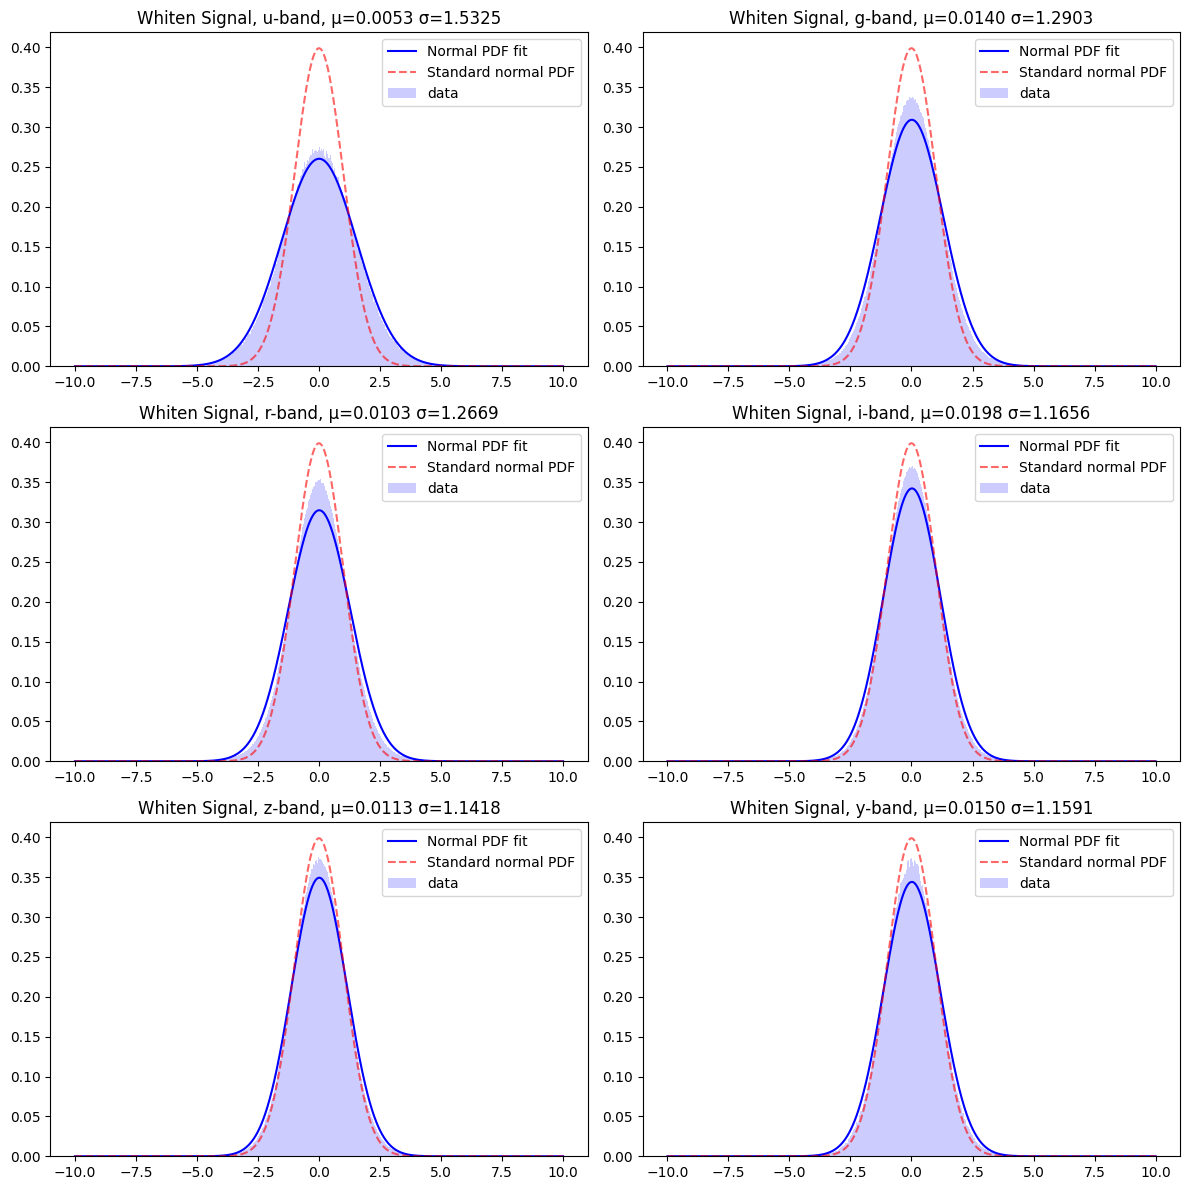

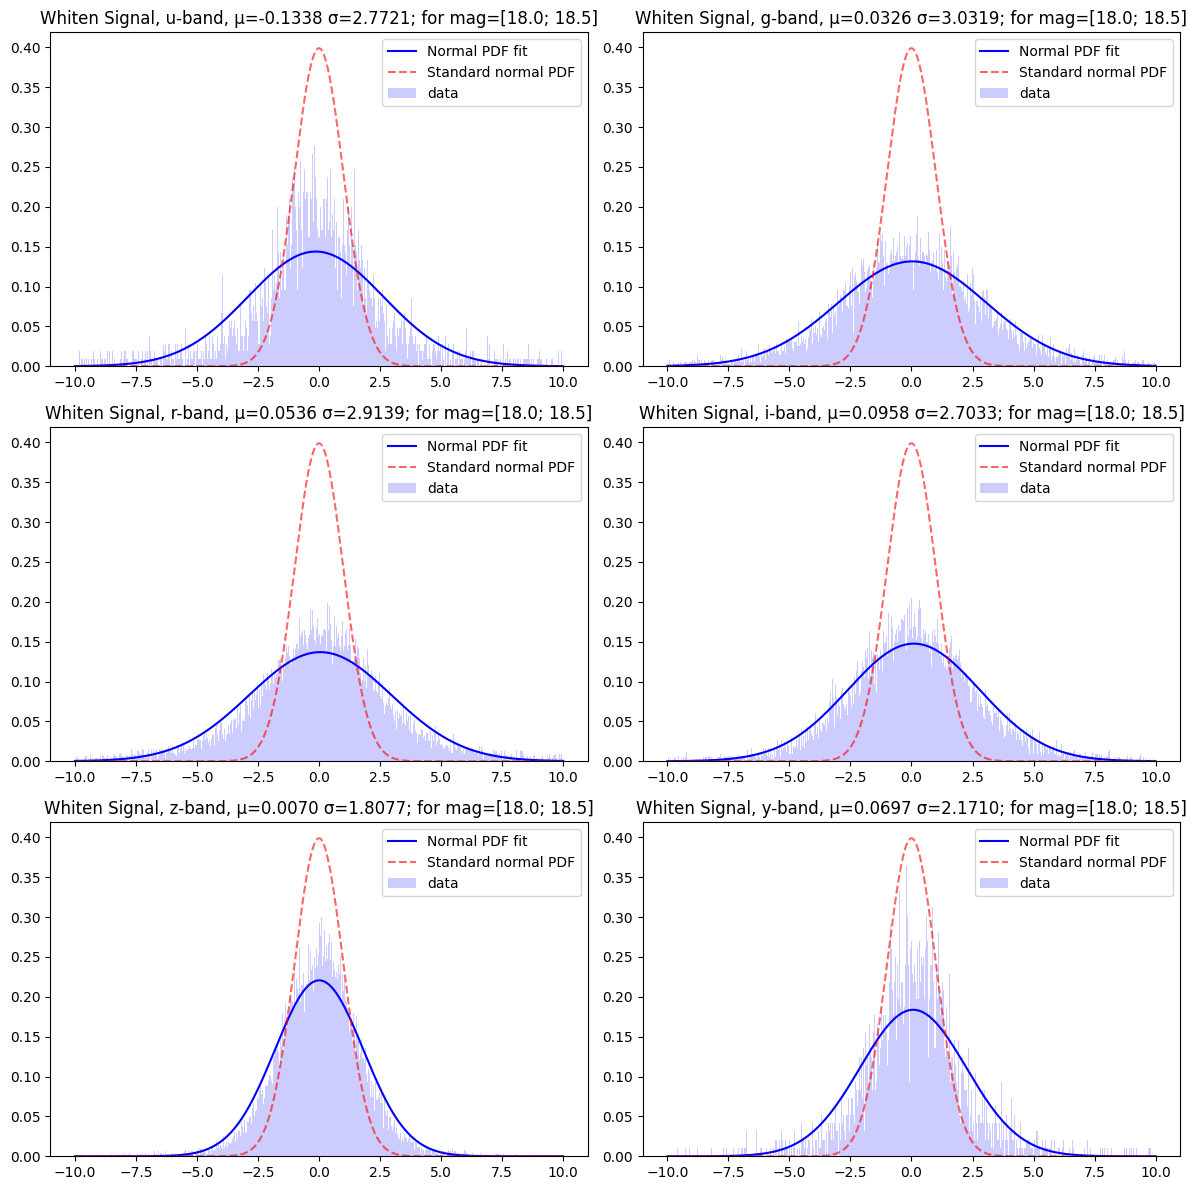

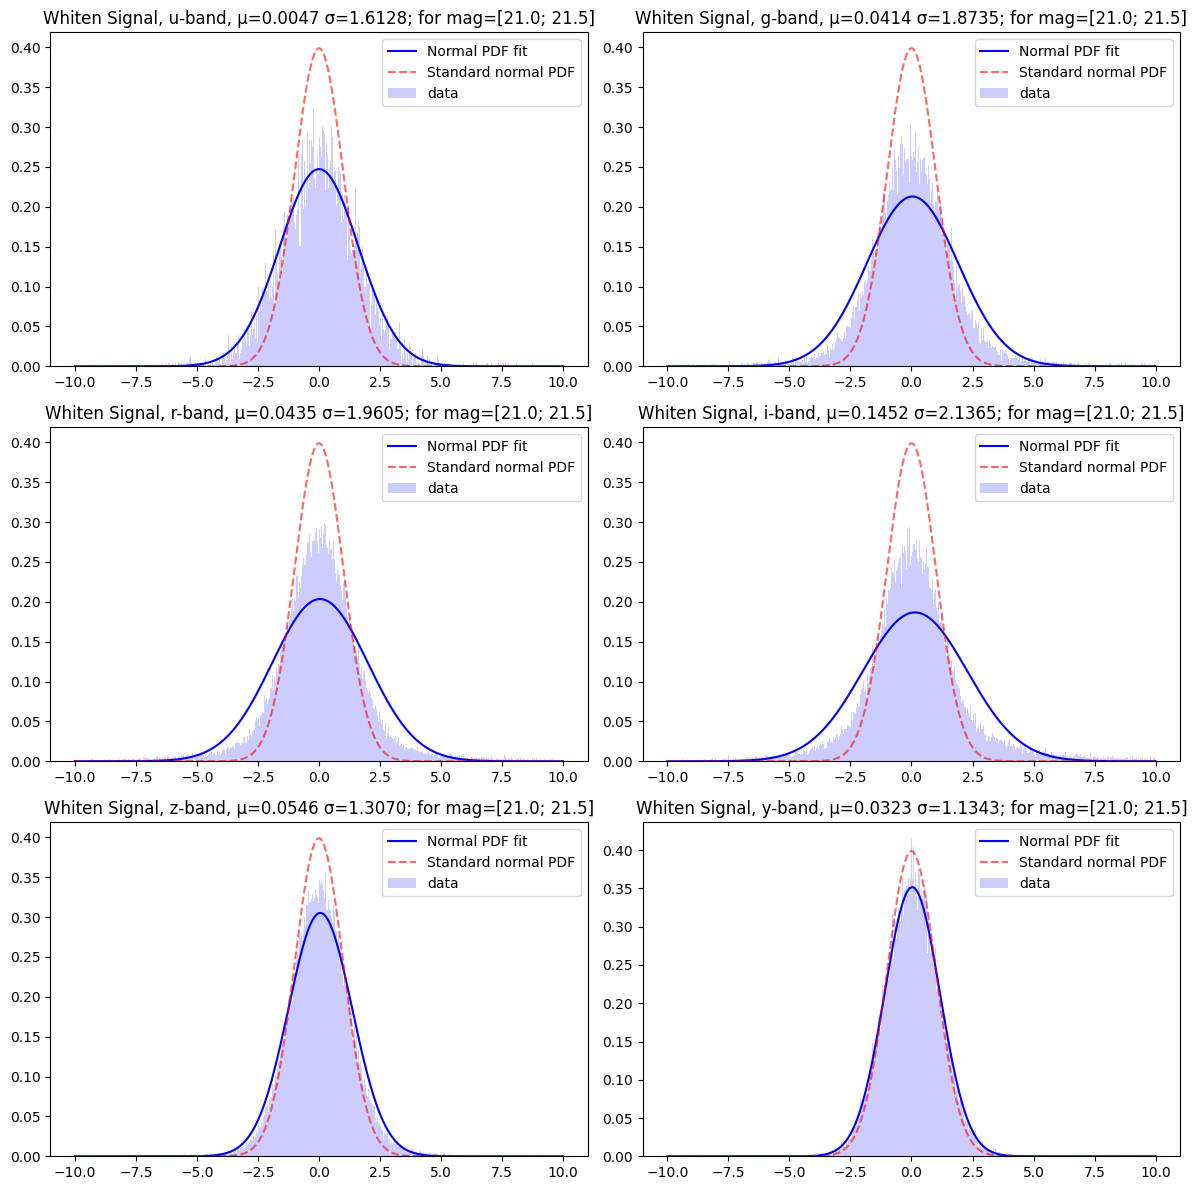

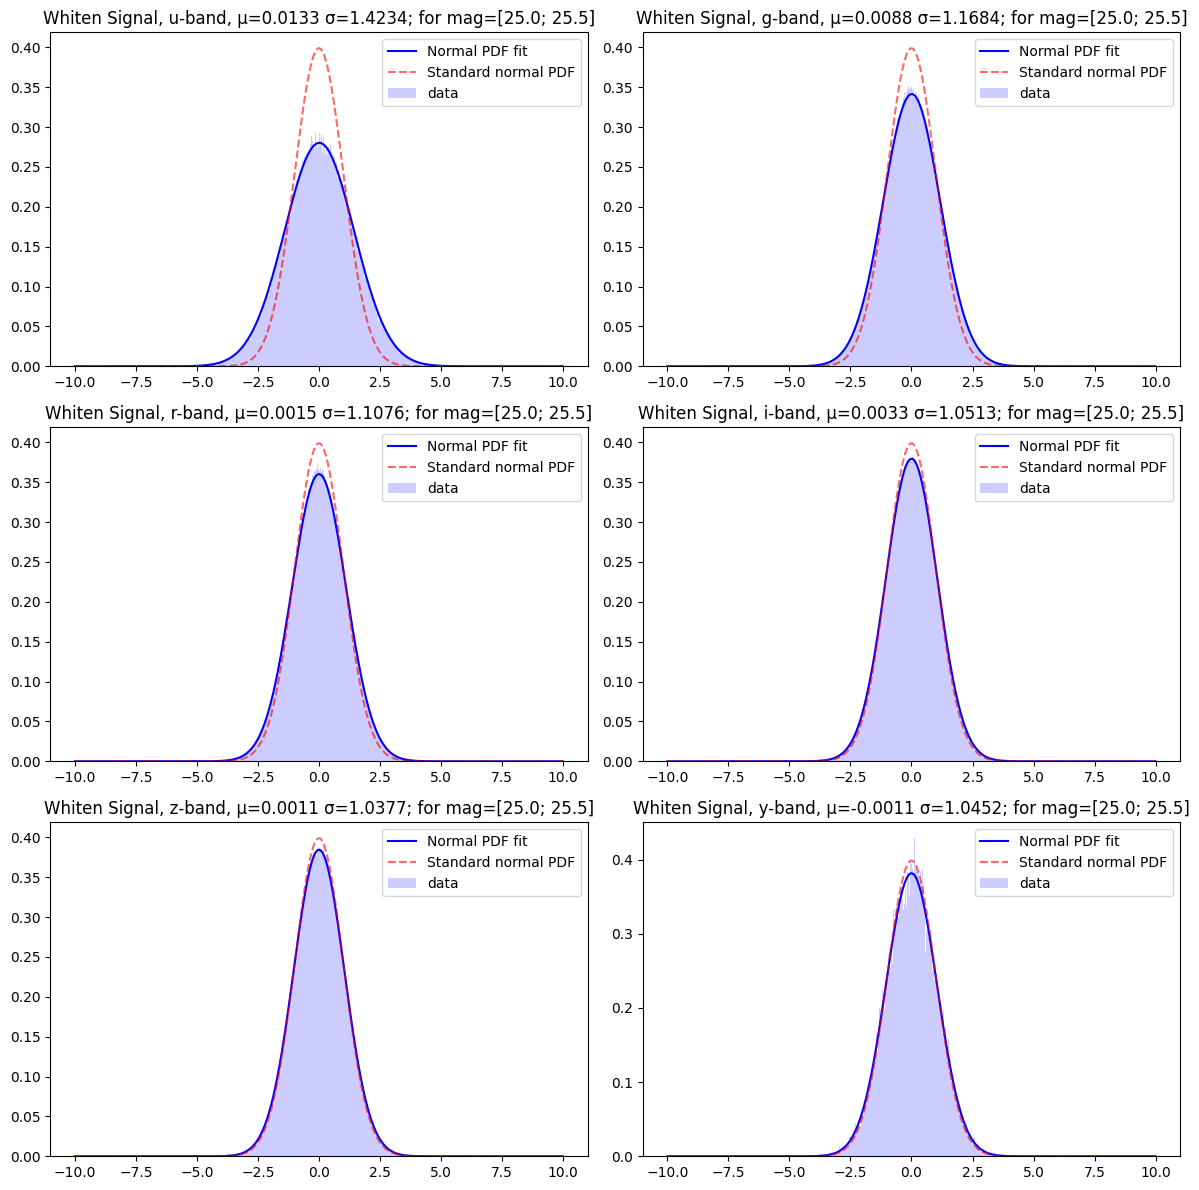

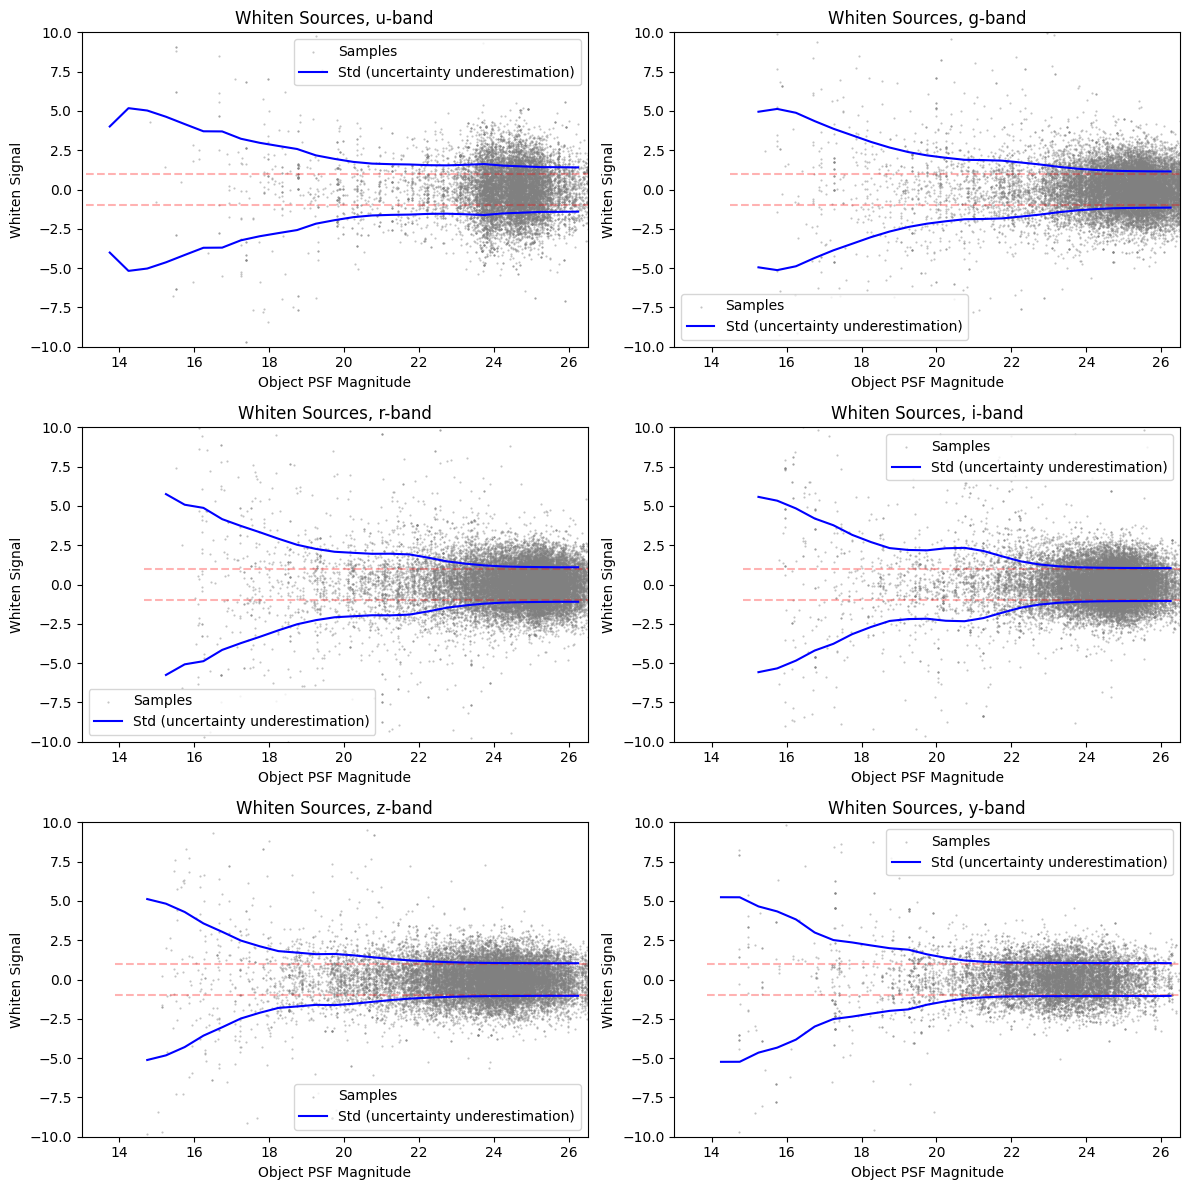

In [3]:
from uncle_val.pipelines import make_plots

make_plots(
    dp1_root=DP1_ROOT,
    hash_range=None,
    min_n_src=N_SRC,
    non_extended_only=False,
    n_workers=LSDB_WORKERS,
    model_path=None,
    n_samples=5,
    object_mags=[18, 21, 25],
)

In [4]:
# %load_ext tensorboard
# %tensorboard --logdir=runs

In [ ]:
from uncle_val.learning.losses import minus_ln_chi2_prob_loss, kl_divergence_whiten_loss
from uncle_val.pipelines import run_dp1_mlp

model_path, model_columns = run_dp1_mlp(
    dp1_root=DP1_ROOT,
    n_workers=LSDB_WORKERS,
    n_src=N_SRC,
    n_lcs=N_LCS,
    loss_fn=kl_divergence_whiten_loss(lmbd=0.001, soft=20.0, kind="accum"),
    train_batch_size=BATCH_SIZE,
    val_batch_size=4098,
    snapshot_every=min(N_LCS // BATCH_SIZE // 50, 2048),
    start_tfboard=True,
    output_root="./runs",
    device=DEVICE,
    load_model_path=LOAD_MODEL,
)

Tensorboard Link: http://localhost:6006/
Dask Dashboard Link: http://127.0.0.1:8787/status


X-Content-Type-Options is required to be "nosniff"
Requires default-src for Content-Security-Policy


Training batch:   0%|          | 0/78125 [00:00<?, ?it/s]

/Users/hombit/.virtualenvs/uncle-val/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:1343: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  current = float(metrics)


In [ ]:
print(model_path)
print(model_columns)

### Train metrics

In [ ]:
from uncle_val.pipelines import make_plots
from uncle_val.pipelines.splits import TRAIN_SPLIT

make_plots(
    dp1_root=DP1_ROOT,
    hash_range=TRAIN_SPLIT,
    min_n_src=N_SRC,
    non_extended_only=False,
    n_workers=LSDB_WORKERS,
    model_path=model_path,
    model_columns=model_columns,
    # model_path="runs/2025-10-10_20-39/mlp.pt",
    # model_columns=['lc.x', 'lc.err', 'extendedness', 'is_u_band', 'is_g_band', 'is_r_band', 'is_i_band', 'is_z_band', 'is_y_band'],
    device=DEVICE,
    n_samples=5,
    object_mags=[18, 21, 25],
)

### Validation metrics

In [ ]:
from uncle_val.pipelines import make_plots
from uncle_val.pipelines.splits import VALIDATION_SPLIT

make_plots(
    dp1_root=DP1_ROOT,
    hash_range=VALIDATION_SPLIT,
    min_n_src=N_SRC,
    non_extended_only=False,
    n_workers=LSDB_WORKERS,
    model_path=model_path,
    model_columns=model_columns,
    # model_path="runs/2025-10-10_20-39/mlp.pt",
    # model_columns=['lc.x', 'lc.err', 'extendedness', 'is_u_band', 'is_g_band', 'is_r_band', 'is_i_band', 'is_z_band', 'is_y_band'],
    device=DEVICE,
    n_samples=5,
    object_mags=[18, 21, 25],
)

### Test metrics

In [ ]:
from uncle_val.pipelines import make_plots
from uncle_val.pipelines.splits import TEST_SPLIT

make_plots(
    dp1_root=DP1_ROOT,
    hash_range=TEST_SPLIT,
    min_n_src=N_SRC,
    non_extended_only=False,
    n_workers=LSDB_WORKERS,
    model_path=model_path,
    model_columns=model_columns,
    # model_path="runs/2025-10-10_20-39/mlp.pt",
    # model_columns=['lc.x', 'lc.err', 'extendedness', 'is_u_band', 'is_g_band', 'is_r_band', 'is_i_band', 'is_z_band', 'is_y_band'],
    device=DEVICE,
    n_samples=5,
    object_mags=[18, 21, 25],
)